In [66]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Machine Learning Preprocessing and Scoring Metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Machine Learning Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [67]:
# Import Data
df = pd.read_csv('data/depression_data.csv')

In the previous notebook we examined each of the null cases to ensure we can impute an appropriate value. We found that:
* Nulls in 'academic pressure' are attributed to non-students.
* Null in 'work pressure' are attributed to non-working professionals.
* Nulls in 'study satisfaction' are attributed to non-students.
* Nulls in 'job satisfaction' are attributed to non-working professionals.

Because of this we will impute:
* 1 for academic pressure, meaning that those that did not respond do not experience academic pressure.
* 1 for work pressure, meaning that those that did not respond do not experience work pressure.
* 3 for study satisfaction, meaning that those that did not respond will be neutral.
* 3 for job satisfaction, meaning that those that did not respond will be neutral.

In [68]:
# Drop ? from naming convention and replace spaces with underscores.
# Also make all columns lower case
df.columns = [column.replace(' ?', '').replace(' ', '_').lower() for column in df.columns]

df.drop(columns=['name'], inplace=True)

In [69]:
# Impute values as specified above
df.loc[:, 'academic_pressure'].fillna(1, inplace=True)
df.loc[:, 'work_pressure'].fillna(1, inplace=True)
df.loc[:, 'study_satisfaction'].fillna(3, inplace=True)
df.loc[:, 'job_satisfaction'].fillna(3, inplace=True)

# Check all values filled as expected
df.isna().sum()

gender                                    0
age                                       0
city                                      0
working_professional_or_student           0
profession                              673
academic_pressure                         0
work_pressure                             0
cgpa                                   2054
study_satisfaction                        0
job_satisfaction                          0
sleep_duration                            0
dietary_habits                            0
degree                                    0
have_you_ever_had_suicidal_thoughts       0
work/study_hours                          0
financial_stress                          0
family_history_of_mental_illness          0
depression                                0
dtype: int64

Neither Profession nor CGPA was statistically significant from our previous notebook. Both contain many null values with no clear best imputation strategy. For these reasons we will drop them from our predicitve model.

In [70]:
df.drop(columns=['profession', 'cgpa'], inplace=True)
df.head()

,gender,age,city,working_professional_or_student,academic_pressure,work_pressure,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,work/study_hours,financial_stress,family_history_of_mental_illness,depression
0,Female,37,Ghaziabad,Working Professional,1.0,2.0,3.0,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Male,60,Kalyan,Working Professional,1.0,4.0,3.0,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Female,42,Bhopal,Working Professional,1.0,2.0,3.0,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Female,44,Thane,Working Professional,1.0,3.0,3.0,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Male,48,Indore,Working Professional,1.0,4.0,3.0,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


At first glance it looks like we can encode:
* gender
* working_professional_or_student
* sleep_duration
* dietary_habits
* have_you_ever_had_suicidal_thoughts
* family_history_of_mental_illness
* depression

In [71]:
# Check current values
print(f"{df['gender'].value_counts()}\n")
print(f"{df['working_professional_or_student'].value_counts()}\n")
print(f"{df['sleep_duration'].value_counts()}\n")
print(f"{df['dietary_habits'].value_counts()}\n")
print(f"{df['have_you_ever_had_suicidal_thoughts'].value_counts()}\n")
print(f"{df['family_history_of_mental_illness'].value_counts()}\n")
print(f"{df['depression'].value_counts()}\n")

gender
Male      1333
Female    1223
Name: count, dtype: int64

working_professional_or_student
Working Professional    2054
Student                  502
Name: count, dtype: int64

sleep_duration
7-8 hours            658
Less than 5 hours    648
5-6 hours            628
More than 8 hours    622
Name: count, dtype: int64

dietary_habits
Unhealthy    882
Healthy      842
Moderate     832
Name: count, dtype: int64

have_you_ever_had_suicidal_thoughts
No     1307
Yes    1249
Name: count, dtype: int64

family_history_of_mental_illness
No     1311
Yes    1245
Name: count, dtype: int64

depression
No     2101
Yes     455
Name: count, dtype: int64



In [72]:
df['sleep_duration'].value_counts()

sleep_duration
7-8 hours            658
Less than 5 hours    648
5-6 hours            628
More than 8 hours    622
Name: count, dtype: int64

In [73]:
# Encode for model ingestion

# Gender
df.loc[:, 'gender'].replace({
    'Female': 0,
    'Male': 1
}, inplace=True)

# Working/Student
df.loc[:, 'working_professional_or_student'].replace({
    'Student': 0,
    'Working Professional': 1
}, inplace=True)

# Sleep Duration
df.loc[:, 'sleep_duration'].replace({
    'Less than 5 hours': 0,
    '5-6 hours': 1,
    '7-8 hours': 2,
    'More than 8 hours': 3
}, inplace=True)

# Diet
df.loc[:, 'dietary_habits'].replace({
    'Unhealthy': 0,
    'Moderate': 1,
    'Healthy': 2
}, inplace=True)

# Previous thoughts of suicide
df.loc[:, 'have_you_ever_had_suicidal_thoughts'].replace({
    'No': 0,
    'Yes': 1
}, inplace=True)

# Family History of Mental Illness
df.loc[:, 'family_history_of_mental_illness'].replace({
    'No': 0,
    'Yes': 1
}, inplace=True)

# Depression
df.loc[:, 'depression'].replace({
    'No': 0,
    'Yes': 1
}, inplace=True)

# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               2556 non-null   int64  
 1   age                                  2556 non-null   int64  
 2   city                                 2556 non-null   object 
 3   working_professional_or_student      2556 non-null   int64  
 4   academic_pressure                    2556 non-null   float64
 5   work_pressure                        2556 non-null   float64
 6   study_satisfaction                   2556 non-null   float64
 7   job_satisfaction                     2556 non-null   float64
 8   sleep_duration                       2556 non-null   int64  
 9   dietary_habits                       2556 non-null   int64  
 10  degree                               2556 non-null   object 
 11  have_you_ever_had_suicidal_tho

In [74]:
# Isolate categorical columns
cat_cols = ['city', 'degree']

# One Hot Encode categorical columns
cat_df = df[cat_cols]
ohe = OneHotEncoder(drop='first', dtype=int, sparse_output=False)
ohe_data = ohe.fit_transform(cat_df)
ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_df.columns))

# Merge encoded data frames together
full_df = pd.merge(df.drop(columns=cat_cols), ohe_df, left_index=True, right_index=True)

In [75]:
# Split training and testing data
X = full_df.drop(columns='depression')
y = full_df['depression']

# Split into training and testing groups
# Stratified sampling maintains class distributions
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify=y, random_state=50)

In [76]:
# Scale training and testing data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [77]:
# Baseline Testing

def test_classification_models(X_train, y_train, cv=10, random_state=50):
    # Define Models to Test
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
        'XGBoost': XGBClassifier(random_state=random_state)
    }
    
    # Set Labels for future Data Frame
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],
        'ROC-AUC': []
    }
    
    # Test each Model and Record Results
    for model_name, model in models.items():
        cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
        results['Model'].append(model_name)
        results['Accuracy'].append(round(np.mean(cv_scores['test_accuracy']) * 100, 2))
        results['Precision'].append(round(np.mean(cv_scores['test_precision']) * 100, 2))
        results['Recall'].append(round(np.mean(cv_scores['test_recall']) * 100, 2))
        results['F1'].append(round(np.mean(cv_scores['test_f1']) * 100, 2))
        results['ROC-AUC'].append(round(np.mean(cv_scores['test_roc_auc']) * 100, 2))
    
    # Create Data Frame and Display
    results_df = pd.DataFrame(results)
    return results_df

In [78]:
test_classification_models(scaled_X_train, y_train)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,97.90,94.55,93.70,94.08,99.69
1,K-Nearest Neighbors,82.73,53.82,23.08,31.76,72.21
2,Decision Tree,90.75,73.79,74.70,74.18,84.46
3,Random Forest,93.69,92.09,70.85,79.81,97.67
4,Gradient Boosting,95.50,93.39,80.77,86.53,98.98
5,XGBoost,96.77,93.69,87.91,90.64,99.36


These results show that Logistic Regression is the best performing model in all measured areas. We can interpret the results as follows:
* `Accuracy`: This model correctly classifies 98% of all survey participants.
* `Precision`: When the model predicts that an individual is at risk, it is correct 95% of the time.
* `Recall`: Of all the at-risk individuals, the model correctly identifies 94% of them.
* `F1 Score`: The high value of 94% indicates a strong balance between correctly identifying at-risk individuals and minimizing false groupings.
* `ROC-AUC`: At >99% this model is performing exceptionally well -- differentiating between groups almost perfectly.

Because our goal is to support medical professionals in indentifying individuals at risk of depression, we want to minimize our false negative rate. This should put more emphasis into Recall as our metric of evaluation. Logistic Regression is the clear winner in this area so let's see if we can perform some hyperparameter tuning in order to improve our current performance.

In [79]:
# Specify parameters
params = {
    'C': [0.1, 1, 10, 100],             # Regularization Strength balances overfitting and underfitting
    'penalty': ['l2'],                  # Ridge maintains all features but penalizes large coefficients
    'solver': ['lbfgs', 'saga']         # Algorithm for optimization
}

# Increased max_iter due to convergence error
log_reg = LogisticRegression(max_iter=10000, random_state=50)

# Pass to GridSearchCV and print best recall score
gs = GridSearchCV(log_reg, params, cv=5, scoring='recall').fit(scaled_X_train, y_train)
print(gs.best_score_)

0.9505707762557076


In [80]:
y_pred = gs.best_estimator_.predict(scaled_X_test)

results = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC-AUC': []
}

from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

results['Accuracy'].append(accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1'].append(f1)
results['ROC-AUC'].append(roc_auc)

pd.DataFrame(results)

,Accuracy,Precision,Recall,F1,ROC-AUC
0,0.986328,0.956522,0.967033,0.961749,0.978766


Wow, an extra 3% performance on recall while maintaining high scores in all other areas. I'd say our model is performing exceptionally well.

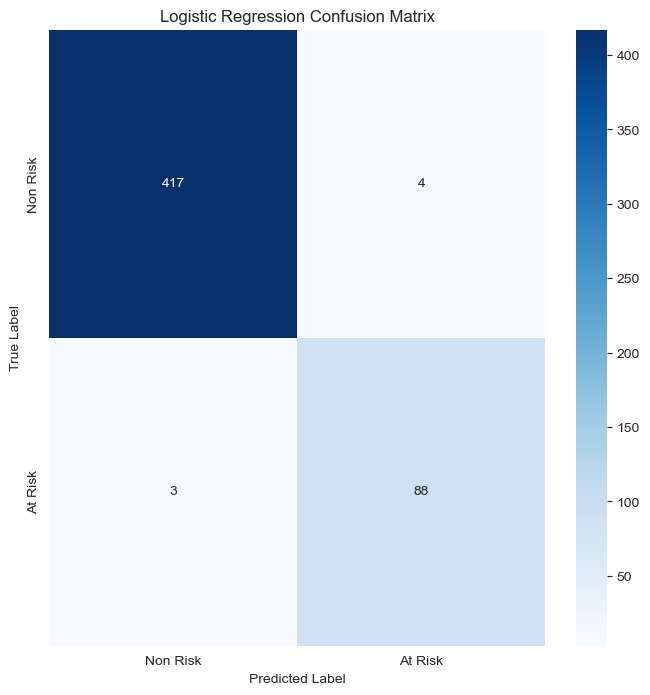

In [81]:
# Create confusion matrix and define labels for visual
cm = confusion_matrix(y_test, y_pred)
labels = ['Non Risk', 'At Risk']

# Format and visualize
figure = plt.subplots(figsize=(8,8))
sns.heatmap(cm,
            annot=True,
            cmap='Blues',
            fmt='.0f',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show();